# Audio dashboard test

In [1]:
AUDIO_CONTROL_PANEL_HEIGHT = '600px'
AUDIO_CONTROL_PANEL_WIDTH = '1000px'
ACCENT_COLOUR = '#c7eef0'

css = f"""
<style>
    .section_heading{{
        background-color : {ACCENT_COLOUR};
        #border : solid 2px {ACCENT_COLOUR};
        margin : 0;
        border-left : solid 5px black;
    }}
    
    .label_setting_box{{
        display : grid;
        grid-template-columns : 50% 40%;
        width : 100%;
    }}

    .start_button{{
        color : green;
    }}
    
    .stop_button{{
        color : red;
    }}
    
    .audio_control_panel{{
        display : flex;
        flex-flow : row nowrap;
        height : {AUDIO_CONTROL_PANEL_HEIGHT};
        width : {AUDIO_CONTROL_PANEL_WIDTH};
    }}
    
    .audio_setup_box{{
        display : flex;
        flex-flow : column nowrap;
        height : 100%;
        width : 40%;
        border-top : solid 2px {ACCENT_COLOUR};
        border-left : solid 2px {ACCENT_COLOUR};
        border-bottom : solid 2px {ACCENT_COLOUR};
        border-right : solid 2px {ACCENT_COLOUR};
    }}
    
    .audio_setup_buttons_box{{
        display : flex;
        flex-flow : row nowrap;
        justify-content : center;
        align-items : center;
        height : 10%;
        width : 100%;
    }}
    
    .audio_setup_parameters_box{{
        display : flex;
        flex-flow : column nowrap;
        justify-content : center;
        align-items : center;
        height : 60%;
        width : 100%;
        border-top : solid 2px {ACCENT_COLOUR};
    }}
    
    .audio_plots_settings_box{{
        display : flex;
        flex-flow : column nowrap;
        justify-content : center;
        align-items : center;
        height : 30%;
        width : 100%;        
        border-top : solid 2px {ACCENT_COLOUR};
    }}
    
    .audio_setup_info_box{{
        display : flex;
        flex-flow : column nowrap;
        justify-content : center;
        align-items : space-around;
        height : 0%;
        width : 100%;
    }}

    .audio_plots_box{{
        display : flex;
        flex-flow : column nowrap;
        height : 100%;
        width : 60%;
        border-top : solid 2px {ACCENT_COLOUR};
        border-bottom : solid 2px {ACCENT_COLOUR};
        border-right : solid 2px {ACCENT_COLOUR};
    }}
    
    .plot_box{{
        height : 100%;
        width : 100%;
    }}
    
</style>
"""

In [2]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

In [3]:
import ipywidgets as widgets
import numpy as np
import traitlets
import plotly.express as px
import plotly.graph_objs as go
import cv2
import math
from colour import Color
from matplotlib import pyplot as plt
import functools
import asyncio

from hearlight.driver import ControlLEDs

"""Test class for software audio processing with CNN

"""
class AudioProcessSoftwareCNN(traitlets.HasTraits):
    weights_trait = traitlets.Dict()
    cnn_version_trait = traitlets.Int()
    
    def __init__(self, panel):
        self.panel = panel
        
        self.panel.start_button.on_click(self._start_button_clicked)
        
        # file upload for weights selection
        self.weights_file_upload = widgets.FileUpload(accept='.dat', multiple=True)
        traitlets.link((self.weights_file_upload, 'value'), (self, 'weights_trait'))
        
        # dropdown for selecting nn version
        self.cnn_version_dropdown = widgets.Dropdown(options=[('v1', 1), ('v2', 2), ('v3', 3)], layout={'width' :  '150px'})
        traitlets.link((self.cnn_version_dropdown, 'value'), (self, 'cnn_version_trait'))

        self.panel.processor_settings = {'Select weights file: ' : self.weights_file_upload,
                                         'Select CNN version: ' : self.cnn_version_dropdown}
        
        self.panel.fig_ft = widgets.HTML(value='Put a spectrogram here...')
        
    def _start_button_clicked(self, button):
        self.run_task = asyncio.ensure_future(self.run())
        
    async def run(self):
        """Do the CNN demo...
        
        """
        pass
        
"""Class for software audio processing with FFT

"""
class AudioProcessSoftwareFFT(traitlets.HasTraits):
    fs_trait = traitlets.Int()
    time_to_run_trait = traitlets.Int()
    n_leds_trait = traitlets.Int()
    n_fft_bins_trait = traitlets.Int()
    min_frequency_trait = traitlets.Float()
    max_frequency_trait = traitlets.Float()
    n_samples_window_trait = traitlets.Int()
    
    def __init__(self, panel):
        self.panel = panel
        
        self.panel.observe(self._setup_fft_plot, ['fs_trait'])
        self.panel.observe(self.setup_demo, ['fs_trait'])
        
        self.panel.start_button.on_click(self._start_button_clicked)
        
        # toggle button for stop button override
        self.panel.stop_button = widgets.ToggleButton(description='STOP', icon='stop')
        self.panel.stop_button.add_class('stop_button')

        # text entry for time to run
        self.time_to_run_entry = widgets.IntText(value=10, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.time_to_run_entry, 'value'), (self, 'time_to_run_trait'))
        
        # text entry for number of LEDs
        self.n_leds_entry = widgets.IntText(value=1, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.n_leds_entry, 'value'), (self, 'n_leds_trait'))
        
        # text entry for number of FFT bins
        self.n_fft_bins_entry = widgets.IntText(value=200, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.n_fft_bins_entry, 'value'), (self, 'n_fft_bins_trait'))
        self.observe(self._setup_fft_plot, ['n_fft_bins_trait'])
        self.observe(self.setup_demo, ['n_fft_bins_trait'])
                
        # text entry for min frequency
        self.min_frequency_entry = widgets.FloatText(value=4000, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.min_frequency_entry, 'value'), (self, 'min_frequency_trait'))
        self.observe(self.tonotopic_map_to_frequencies, ['min_frequency_trait'])
        self.observe(self.setup_demo, ['min_frequency_trait'])

        # text entry for max frequency
        self.max_frequency_entry = widgets.FloatText(value=32000, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.max_frequency_entry, 'value'), (self, 'max_frequency_trait'))
        self.observe(self.tonotopic_map_to_frequencies, ['max_frequency_trait'])
        
        # number of time samples to perform FFT
        self.n_samples_window_entry = widgets.IntText(value=2048, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.n_samples_window_entry, 'value'), (self, 'n_samples_window_trait'))
        self.observe(self.setup_demo, ['n_samples_window_trait'])
        
        self.panel.processor_settings = {'Time to run (s): ' : self.time_to_run_entry,
                                'Number of LEDs: ' : self.n_leds_entry,
                                'Number of FFT bins: ' : self.n_fft_bins_entry,
                                'Minimum frequency (Hz): ' : self.min_frequency_entry,
                                'Maximum frequency (Hz): ' : self.max_frequency_entry,
                                'Number of samples in window: ' : self.n_samples_window_entry}
        
        # PLOTS SETUP
        # frequency domain plot
        # divide by 2 as we will only look at positive frequencies
        buffer_ft = np.zeros(int(self.n_fft_bins_trait/2))
        ft_mag_line = px.line(x = np.linspace(0, int(self.panel.fs_trait/2), int(self.n_fft_bins_trait/2)),
                              y = buffer_ft)
        self.panel.fig_ft = go.FigureWidget(ft_mag_line)
        
        self._setup_fft_plot(0)
        
        # generate frequency map from image of tonotopic map
        self.tonotopic_map_to_frequencies(0)
        
        # setup audio processing with FFT demo
        self.setup_demo(0)
        
        self.system = ControlLEDs(base)
        
        # ALL SWITCHES OPEN
        for i in range(10):
            self.system.switch_control(i, 0)
            
        # SWITCH OFF ALL DAC CHANNELS
        for i in range(10):
            self.system.dac_channel_control(i, 0, 0)
            
        # SET SOFTSPAN RANGE FOR ALL DACS
        for i in range(10):
            self.system.dac_config(i, 1)
        
        # Configure audio input
        self.pAudio = base.audio
        self.pAudio.select_line_in()
                
    def _setup_fft_plot(self, trait_change):
        # frequency domain plot
        # divide by 2 as we will only look at positive frequencies
        buffer_ft = np.zeros(int(self.n_fft_bins_trait/2))
        self.panel.fig_ft.data[0].update({'x' : np.linspace(0, int(self.panel.fs_trait/2), int(self.n_fft_bins_trait/2))})
        self.panel.fig_ft.data[0].update({'y' : buffer_ft})

        self.panel.fig_ft.update_layout(xaxis = {'title' : 'frequency (Hz)'})
        self.panel.fig_ft.update_layout(yaxis = {'title' : 'magnitude'})
        self.panel.fig_ft.update_layout(title = {'text' : 'Fourier Transform Magnitude'})

    def show_original_tonotopic_map(self):
        plt.imshow(cv2.cvtColor(self.im, cv2.COLOR_BGR2RGB))
        plt.show()

    def show_sampled_tonotopic_map(self):
        plt.imshow(self.im_sampled)
        plt.show()
        
    def tonotopic_map_to_frequencies(self, trait_change):
        """Converts an image of the tonotopic map to a frequency map. This should be changed to a better solution.
        
        """
        self.im = cv2.imread(f'tonotopic_map_image.png')

        self.im_sampled = self.im[10::math.ceil(np.shape(self.im)[0]/10), 0::math.ceil(np.shape(self.im)[1]/10), :]
        self.im_sampled = cv2.cvtColor(self.im_sampled, cv2.COLOR_BGR2RGB)
        
        # go from red to blue as image is BGR
        red = Color("blue")
        n_colours = 20
        colours = list(red.range_to(Color("red"), n_colours))

        frequencies = np.linspace(start=self.min_frequency_trait, stop=self.max_frequency_trait, num=n_colours)

        colours_list_rgb = [colour.rgb for colour in colours]
        colours_image_rgb = self.im_sampled/255

        # get frequency bin for each location on sampled tonotopic map
        self.frequency_map = np.zeros((10,10))

        for r in range(10):
            for c in range(10):
                # use euclidean distance to get frequency bins for tonotopic map image
                idx = np.argmin(np.array([np.linalg.norm(colours_list_rgb[colour] - colours_image_rgb[r, c, :]) for colour in range(n_colours)]))

                self.frequency_map[r, c] = frequencies[idx]
                
    def setup_demo(self, trait_change):
        """Use frequency map generated from image of tonotopic map to create mapping of FFT bins to grid.
        
        """
        # GENERATE MAPPING OF FREQUENCY TO GRID
        self.ft_bins = np.linspace(0, self.panel.fs_trait/2, int(self.n_fft_bins_trait/2))

        # location of minimum frequency in ft
        self.idx_min = np.argmin(np.abs(self.ft_bins - self.min_frequency_trait))
        self.idx_max = np.argmax(np.abs(self.ft_bins - self.min_frequency_trait))
        ft_bins_in_range = np.linspace(self.ft_bins[self.idx_min], self.ft_bins[self.idx_max], 100)

        self.ft_bin_indices_to_grid = [[np.argmin(np.abs(ft_bins_in_range-self.frequency_map[r,c])) for c in range(10)] for r in range(10)]
        
        self.sample_time = self.n_samples_window_trait / self.panel.fs_trait
        
        self.threshold = 10000
        
    def _start_button_clicked(self, button):
        self.run_task = asyncio.ensure_future(self.run())
        
    async def run(self):
        """Run demo for specified time.
        
        """
        for i in range(int(self.time_to_run_trait / self.sample_time)):
            # time domain plot
            self.pAudio.record(seconds=self.sample_time)
            buffer_signed = ((self.pAudio.buffer << 8).view(np.int32) >> 8)[0::2] # change to signed int and look at one channel (mono)
            
            # UPDATE TIME PLOT
            if self.panel.time_plot_pause_toggle.value == False:
                self.panel.fig.data[0].update({'y' : np.concatenate([self.panel.fig.data[0]['y'][self.n_samples_window_trait:], buffer_signed])})

            # compute fft
            ft = abs(np.fft.fft(buffer_signed))[0:int(self.n_fft_bins_trait/2)]
            
            # UPDATE FREQUENCY PLOT
            if self.panel.freq_plot_pause_toggle.value == False:
                self.panel.fig_ft.data[0].update({'y' : ft})

            ft_bin_max_values = np.array([max(arr) for arr in np.array_split(ft, 100)])
            ft_bin_max_values_norm = ft_bin_max_values/1000000

            # translate values to grid
            ft_bin_values_on_grid = (ft_bin_max_values_norm[np.array(self.ft_bin_indices_to_grid)]*65535).astype(np.uint16)
            ft_bin_values_on_grid[ft_bin_values_on_grid < self.threshold] = 0
            
            np.argpartition(ft_bin_values_on_grid.reshape(100,), -self.n_leds_trait)[-self.n_leds_trait:]
            indices = np.unravel_index(np.argpartition(ft_bin_values_on_grid.reshape(100,), -self.n_leds_trait)[-self.n_leds_trait:], (10,10))

            [self.system.dac_channel_control(channel, 0, 0) for channel in range(10) if channel not in [(9-indices[1][led]) for led in range(self.n_leds_trait)]]
            [self.system.switch_control(sw, 0) for sw in range(10) if sw not in [indices[0][led] for led in range(self.n_leds_trait)]]
                        
            for led in range(self.n_leds_trait):
                self.system.switch_control(indices[0][led], 1)
                self.system.dac_channel_control(9-indices[1][led], 1, int(ft_bin_values_on_grid[indices[0][led], indices[1][led]]))
            
            if self.panel.stop_button.value:
                self.panel.stop_button.value = False
                break
            
            if i%10 == 0:
                await asyncio.sleep(0.001)
            

        # SWITCH OFF ALL DAC CHANNELS
        for i in range(10):
            self.system.dac_channel_control(i, 0, 0)

        # ALL SWITCHES OPEN
        for i in range(10):
            self.system.switch_control(i, 0)

In [4]:
import ipywidgets as widgets
import numpy as np
import traitlets
import plotly.express as px
import plotly.graph_objs as go

"""Class for audio control panel

"""
class AudioControlPanel(traitlets.HasTraits):
    fs_trait = traitlets.Int()
    n_samples_plot_trait = traitlets.Int()
    
    def __init__(self, *audio_processors):
        # text entry for audio sample frequency
        self.fs_entry = widgets.IntText(value=48000, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.fs_entry, 'value'), (self, 'fs_trait'))
                
        # button to start audio stream and device control
        self.start_button = widgets.Button(description='START', icon='play')
        self.start_button.add_class('start_button')

        # button to stop audio stream and device control
        self.stop_button = widgets.Button(description='STOP', icon='stop')
        self.stop_button.add_class('stop_button')
        
        ## audio plots settings
        # number of time samples to show on plot
        self.n_samples_plot_entry = widgets.IntText(value=20480, disabled=False, layout = {'width' : '100%'})
        traitlets.link((self.n_samples_plot_entry, 'value'), (self, 'n_samples_plot_trait'))
        self.observe(self._setup_plots, ['n_samples_plot_trait'])
        
        # toggle button to pause/resume time domain plot update
        self.time_plot_pause_toggle = widgets.ToggleButton(description='Pause time domain plot update', icon='pause', layout = {'width' : '250px'})
        self.time_plot_pause_toggle.add_class('time_plot_pause_toggle')
        
        # toggle button to pause/resume freq domain plot update
        self.freq_plot_pause_toggle = widgets.ToggleButton(description='Pause frequency domain plot update', icon='pause', layout = {'width' : '250px'})
        self.freq_plot_pause_toggle.add_class('freq_plot_pause_toggle')

        # PLOTS SETUP
        # time domain plot
        plot_data = np.zeros(self.n_samples_plot_trait)
        line = px.line(x = np.arange(0, self.n_samples_plot_trait, 1),
                       y = plot_data)
        self.fig = go.FigureWidget(line, layout = go.Layout(xaxis = {'title' : 'sample'},
                                              yaxis = {'title' : 'amplitude'}))
        self.fig_ft = go.FigureWidget()

        self.processor_settings = {}
        
        for audio_processor in audio_processors:
            self.processor = audio_processor(self)
        
        self._setup_plots(0)
        self._layout_panel()
                
    def _layout_panel(self):
        ### audio control panel box
        self.audio_control_panel = widgets.Box()
        self.audio_control_panel.add_class('audio_control_panel')
        self.audio_control_panel.children += (widgets.HTML(value=css),)
        
        ## audio setup box (start/stop button and parameters)
        audio_setup_box = widgets.Box()
        audio_setup_box.add_class('audio_setup_box')
        audio_setup_box_heading = widgets.HTML(value='<b>&nbsp;Audio setup</b>')
        audio_setup_box_heading.add_class('section_heading')
        audio_setup_box.children += (audio_setup_box_heading,)
        self.audio_control_panel.children += (audio_setup_box,)
        
        # audio setup buttons box (start/stop)
        audio_setup_buttons_box = widgets.Box()
        audio_setup_buttons_box.add_class('audio_setup_buttons_box')
        audio_setup_buttons_box.children += (self.start_button, self.stop_button, )
        audio_setup_box.children += (audio_setup_buttons_box,)
        
        # audio setup parameters box (n_fft_bins etc)
        audio_setup_parameters_box = widgets.Box()
        audio_setup_parameters_box.add_class('audio_setup_parameters_box')
        
        # place all setup parameters boxes into a tuple
        fs_entry_box = widgets.Box()
        fs_entry_box.add_class('label_setting_box')
        fs_entry_box.children += (widgets.HTML(value=f"<font color='black'>Audio sample frequency (Hz): "), self.fs_entry, )
        audio_setup_parameters = ()
        audio_setup_parameters += (fs_entry_box, )
        
        # add inherited settings
        for label, widget in self.processor_settings.items():
            box = widgets.Box()
            box.add_class('label_setting_box')
            box.children += (widgets.HTML(value=f"<font color='blue'>{label}"), widget, )
            audio_setup_parameters += (box, )

        audio_setup_parameters_box.children += audio_setup_parameters
        audio_setup_box.children += (audio_setup_parameters_box,)
        
        # audio plot settings box
        audio_plots_settings_box = widgets.Box()
        audio_plots_settings_box.add_class('audio_plots_settings_box')
        audio_plots_settings_box
        
        n_samples_plot_entry_box = widgets.Box()
        n_samples_plot_entry_box.add_class('label_setting_box')
        n_samples_plot_entry_box.children += (widgets.Label('Number of samples on plot: '), self.n_samples_plot_entry, )
        
        time_plot_pause_toggle_box = widgets.Box()
        time_plot_pause_toggle_box.children += (self.time_plot_pause_toggle,)
        
        freq_plot_pause_toggle_box = widgets.Box()
        freq_plot_pause_toggle_box.children += (self.freq_plot_pause_toggle,)
        
        audio_plots_settings = (n_samples_plot_entry_box,
                                time_plot_pause_toggle_box,
                                freq_plot_pause_toggle_box,)
        audio_plots_settings_box.children += audio_plots_settings
        audio_setup_box.children += (audio_plots_settings_box,)
        
        # audio setup info box
        audio_setup_info_box = widgets.Box()
        audio_setup_info_box.add_class('audio_setup_info_box')
        audio_setup_box.children += (audio_setup_info_box,)
        
        ## audio plots box (audio stream/FFT or spectrogram later... and buttons to disable plot updates)
        audio_plots_box = widgets.Box()
        audio_plots_box.add_class('audio_plots_box')
        audio_plots_box_heading = widgets.HTML(value='<b>&nbsp;Audio plots</b>')
        audio_plots_box_heading.add_class('section_heading')
        audio_plots_box.children += (audio_plots_box_heading,)
        self.audio_control_panel.children += (audio_plots_box,)
                
        # audio plots time domain plot
        time_plot_box = widgets.Box()
        time_plot_box.add_class('plot_box')
        time_plot_box.children += (self.fig,)
        audio_plots_box.children += (time_plot_box,)        
        
        # audio plots freq domain plot
        freq_plot_box = widgets.Box()
        freq_plot_box.add_class('plot_box')
        freq_plot_box.children += (self.fig_ft,)
        audio_plots_box.children += (freq_plot_box,)
        
    def _setup_plots(self, trait_change):
        # time domain plot
        plot_data = np.zeros(self.n_samples_plot_trait)
        self.fig.data[0].update({'x' : np.arange(0, self.n_samples_plot_trait, 1)})
        self.fig.data[0].update({'y' : plot_data})
        
        self.fig.update_layout(xaxis = {'title' : 'sample index'})
        self.fig.update_layout(yaxis = {'title' : 'amplitude'})
        self.fig.update_layout(title = {'text' : 'Audio signal in time domain'})

        # MAKE THIS MORE DETERMINISTIC....
        self.fig.update_yaxes(
            range=(-100000, 100000),
            constrain='domain'
        )
        

# TEST

In [14]:
audio_control_panel = AudioControlPanel(AudioProcessSoftwareFFT)

In [15]:
audio_control_panel.audio_control_panel

Box(children=(HTML(value='\n<style>\n    .section_heading{\n        background-color : #c7eef0;\n        #bord…

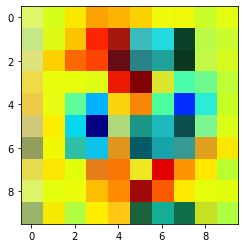

In [9]:
audio_control_panel.processor.show_sampled_tonotopic_map()

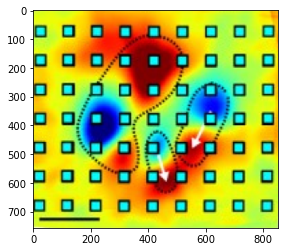

In [10]:
audio_control_panel.processor.show_original_tonotopic_map()

In [11]:
audio_control_panel.processor.frequency_map

array([[24631.57894737, 23157.89473684, 26105.26315789, 27578.94736842,
        27578.94736842, 26105.26315789, 24631.57894737, 24631.57894737,
        23157.89473684, 24631.57894737],
       [23157.89473684, 24631.57894737, 26105.26315789, 30526.31578947,
        32000.        , 12842.10526316,  9894.73684211, 17263.15789474,
        23157.89473684, 23157.89473684],
       [24631.57894737, 26105.26315789, 29052.63157895, 30526.31578947,
        32000.        ,  6947.36842105, 14315.78947368, 17263.15789474,
        23157.89473684, 24631.57894737],
       [26105.26315789, 24631.57894737, 24631.57894737, 24631.57894737,
        32000.        , 32000.        , 24631.57894737, 12842.10526316,
        14315.78947368, 23157.89473684],
       [26105.26315789, 24631.57894737, 14315.78947368,  8421.05263158,
        26105.26315789, 29052.63157895, 14315.78947368,  5473.68421053,
        12842.10526316, 23157.89473684],
       [26105.26315789, 24631.57894737,  9894.73684211,  4000.        ,
   

# LED TEST

In [58]:
system = ControlLEDs(base)

In [59]:
# ALL SWITCHES OPEN
for i in range(10):
    system.switch_control(i, 0)

In [60]:
# SWITCH OFF ALL DAC CHANNELS
for i in range(10):
    system.dac_channel_control(i, 0, 0)

In [61]:
# SET SOFTSPAN RANGE FOR ALL DACS
for i in range(10):
    system.dac_config(i, 1)

In [62]:
from time import sleep

# ALL SWITCHES CLOSE
for i in range(10):
    system.switch_control(i, 1)
# SWITCH ON ALL DAC CHANNELS
for i in range(10):
    system.dac_channel_control(i, 1, 65535)

sleep(5)

# SWITCH OFF ALL DAC CHANNELS
for i in range(10):
    system.dac_channel_control(i, 0, 0)
# ALL SWITCHES OPEN
for i in range(10):
    system.switch_control(i, 0)